In [ ]:
# !pip install -q transformers

In [ ]:
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel, DistilBertTokenizer, AutoTokenizer, TFAutoModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_base_cased = TFBertModel.from_pretrained('bert-base-cased')

distilroberta_tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
distilroberta = TFAutoModel.from_pretrained('distilroberta-base')

distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import os
import csv
from functools import reduce

import tensorflow as tf
from tensorflow import keras
from transformers import logging
logging.set_verbosity_error()

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Create training and evaluation data

This code I executed only once to create the training and evaluation datasets. I wanted to ensure that I was training and evaluating each model on the same data.

In [ ]:
# read data
file_path_fake = '/content/drive/MyDrive/archive/DataSet_Misinfo_FAKE.csv'
file_path_true = '/content/drive/MyDrive/archive/DataSet_Misinfo_TRUE.csv'
file_path_rus = '/content/drive/MyDrive/archive/EXTRA_RussianPropagandaSubset.csv'

input_text_fake = pd.read_csv(file_path_fake)
input_text_true = pd.read_csv(file_path_true)
input_text_rus = pd.read_csv(file_path_rus)

In [ ]:
# add labels
input_text_fake.insert(input_text_fake.shape[1], 'label', 1)
input_text_true.insert(input_text_true.shape[1], 'label', 0)
input_text_rus.insert(input_text_rus.shape[1], 'label', 1)

In [ ]:
input_text_true['text'][0]

In [ ]:
input_text_fake['text'][0]

In [ ]:
input_text_rus['text'][0]

In [ ]:
# shuffle input
input_text_fake = shuffle(input_text_fake)
input_text_true = shuffle(input_text_true)
input_text_rus = shuffle(input_text_rus)

In [ ]:
# grab 10k records for pretraining
input_text_fake_train = input_text_fake[0:5000]
input_text_true_train = input_text_true[0:5000]

print('Train shape:')
print(input_text_fake_train.shape)
print(input_text_true_train.shape)

input_text = pd.concat([input_text_fake_train, input_text_true_train], ignore_index=True)
input_text = input_text[['text', 'label']]
input_text = input_text.astype(str)

input_text.to_csv('/content/drive/MyDrive/training/input_text.csv', index=False)

In [ ]:
# grab 15k records for evaluation
input_text_fake_eval = input_text_fake[10000:15000]
input_text_true_eval = input_text_true[10000:15000]
input_text_rus_eval = input_text_rus[0:5000]

print('Eval shape:')
print(input_text_fake_eval.shape)
print(input_text_true_eval.shape)
print(input_text_rus_eval.shape)

eval_text = pd.concat([input_text_fake_eval, input_text_true_eval, input_text_rus_eval], ignore_index=True)
eval_text = eval_text[['text', 'label']]
eval_text = eval_text.astype(str)

eval_text.to_csv('/content/drive/MyDrive/evaluation/eval_text.csv', index=False)

#Model Pretraining

In [ ]:
input_text = pd.read_csv('/content/drive/MyDrive/training/input_text.csv')

input_text = input_text.astype({'text': str, 'label': bool})

In [ ]:
print(input_text.head())

                                                text  label
0  Wow! Republicans had a chance to stand up to t...   True
1  Who needs family when you have a neighborhood ...   True
2  West Virginia is solid Trump country. The argu...   True
3  Chart Of The Day: Wealth Of the Top 0.1% Now E...   True
4  Terrorists attacked Brussels, Belgium in a tra...   True


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(input_text['text'], input_text['label'], test_size=0.1)

In [ ]:
print(train_labels.shape)
print(test_labels.shape)

(9000,)
(1000,)


## Model parameters
I fine tuned each model using one set of parameters and then restarted my instance in order to free up resources for the next set of parameters.

In [ ]:
# 'small' model hyperparameters
max_length = 200
batch_size = 4
epochs = 2

In [ ]:
# 'small' model hyperparameters
max_length = 200
batch_size = 8
epochs = 2

In [ ]:
# 'large' model hyperparameters
max_length = 500
batch_size = 4
epochs = 2

In [ ]:
# 'large' model hyperparameters
max_length = 500
batch_size = 8
epochs = 2

In [ ]:
base_train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
base_train_inputs = [base_train_encodings.input_ids,
                    base_train_encodings.token_type_ids,
                    base_train_encodings.attention_mask]

base_test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
base_test_inputs = [base_test_encodings.input_ids,
                    base_test_encodings.token_type_ids,
                    base_test_encodings.attention_mask]

In [ ]:
distilroberta_train_encodings = distilroberta_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
distilroberta_train_inputs = [distilroberta_train_encodings.input_ids,
                              distilroberta_train_encodings.attention_mask]

distilroberta_test_encodings = distilroberta_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
distilroberta_test_inputs = [distilroberta_test_encodings.input_ids,
                             distilroberta_test_encodings.attention_mask]

In [ ]:
distilbert_train_encodings = distilbert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
distilbert_train_inputs = [distilbert_train_encodings.input_ids,
                           distilbert_train_encodings.attention_mask]

distilbert_test_encodings = distilbert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
distilbert_test_inputs = [distilbert_test_encodings.input_ids,
                          distilbert_test_encodings.attention_mask]

In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [ ]:
# save model weights for later evaluation
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/small/batch4/'
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/small/batch8/'
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/large/batch4/'
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/large/batch8/'

checkpoint_filepath = checkpoint_dir + 'bert_base_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
bert_base_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

checkpoint_filepath = checkpoint_dir + 'distilroberta_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
distilroberta_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

checkpoint_filepath = checkpoint_dir + 'distilbert_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
distilbert_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [ ]:
def create_model(model_selection,
                 model,
                 max_sequence_length=max_length,
                 hidden_size=100,
                 dropout=0.3,
                 learning_rate=0.00005):
    """
    Builds a classification model. Includes options for training BERT, DistilRoberta, and DistilBert.
    """

    model.trainable = True

    if model_selection == 'bert_base_cased':
      input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
      token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

      bert_inputs = {'input_ids': input_ids,
                     'token_type_ids': token_type_ids,
                     'attention_mask': attention_mask}
    else:
      input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

      bert_inputs = {'input_ids': input_ids,
                     'attention_mask': attention_mask}

    bert_out = model(bert_inputs)

    if model_selection == 'bert_base_cased':
      reduced_bert_out = tf.math.reduce_mean(bert_out[0], axis=1)
      dropout_layer = tf.keras.layers.Dropout(dropout, name='dropout_layer')(reduced_bert_out)
    else:
      cls_token = bert_out[0][:, 0, :]
      dropout_layer = tf.keras.layers.Dropout(dropout, name='dropout_layer')(cls_token)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(dropout_layer)
    classification_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    if model_selection == 'bert_base_cased':
      classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification_layer])

    else:
      classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification_layer])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


In [ ]:
bert_base_model = create_model('bert_base_cased', bert_base_cased, max_length)

bert_base_model_history = bert_base_model.fit(base_train_inputs,
                                              train_labels,
                                              validation_data=(base_test_inputs, test_labels),
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              callbacks=[bert_base_checkpoint_callback]
                                              )


Epoch 1/2


2250/2250 [==============================] - 1197s 515ms/step - loss: 0.1902 - accuracy: 0.9299 - val_loss: 0.2008 - val_accuracy: 0.9270
Epoch 2/2
2250/2250 [==============================] - 1152s 512ms/step - loss: 0.0879 - accuracy: 0.9698 - val_loss: 0.0773 - val_accuracy: 0.9780


In [ ]:
print(bert_base_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                      

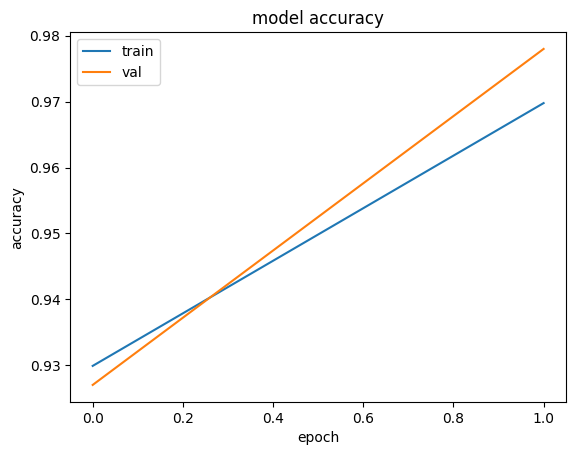

In [ ]:
plt.plot(bert_base_model_history.history['accuracy'])
plt.plot(bert_base_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
distilroberta_model = create_model('distilroberta', distilroberta, max_length)

distilroberta_model_history = distilroberta_model.fit(distilroberta_train_inputs,
                                                      train_labels,
                                                      validation_data=(distilroberta_test_inputs, test_labels),
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      callbacks=[distilroberta_checkpoint_callback]
                                                      )


Epoch 1/2


2250/2250 [==============================] - 624s 269ms/step - loss: 0.0992 - accuracy: 0.9648 - val_loss: 0.0430 - val_accuracy: 0.9880
Epoch 2/2
2250/2250 [==============================] - 591s 263ms/step - loss: 0.0423 - accuracy: 0.9884 - val_loss: 0.0474 - val_accuracy: 0.9770


In [ ]:
print(distilroberta_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8211840   ['attention_mask_layer[0][0]',
 aModel)                     ngAndCrossAttentions(last_   0          'input_ids_layer[0][0]'

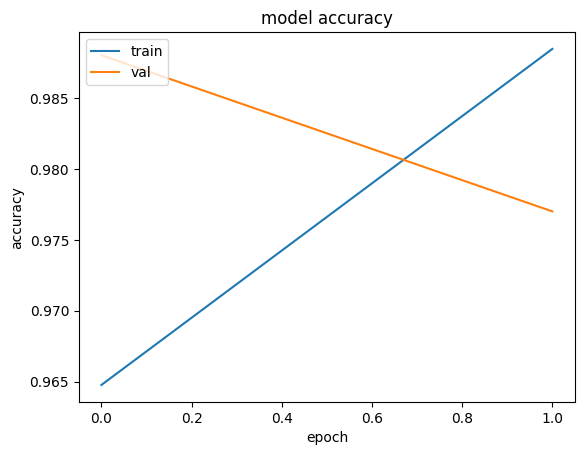

In [ ]:
plt.plot(distilroberta_model_history.history['accuracy'])
plt.plot(distilroberta_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
distill_bert_model = create_model('distilbert', distilbert, max_length)

distill_bert_model_history = distill_bert_model.fit(distilbert_train_inputs,
                                                    train_labels,
                                                    validation_data=(distilbert_test_inputs, test_labels),
                                                    batch_size=batch_size,
                                                    epochs=epochs,
                                                    callbacks=[distilbert_checkpoint_callback]
                                                    )


Epoch 1/2
2250/2250 [==============================] - 624s 268ms/step - loss: 0.1593 - accuracy: 0.9392 - val_loss: 0.1000 - val_accuracy: 0.9640
Epoch 2/2
2250/2250 [==============================] - 573s 255ms/step - loss: 0.0576 - accuracy: 0.9804 - val_loss: 0.1105 - val_accuracy: 0.9720


In [ ]:
print(distill_bert_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['attention_mask_layer[0][0]',
 stilBertModel)              den_state=(None, 500, 768)   0          'input_ids_layer[0][0]'] 

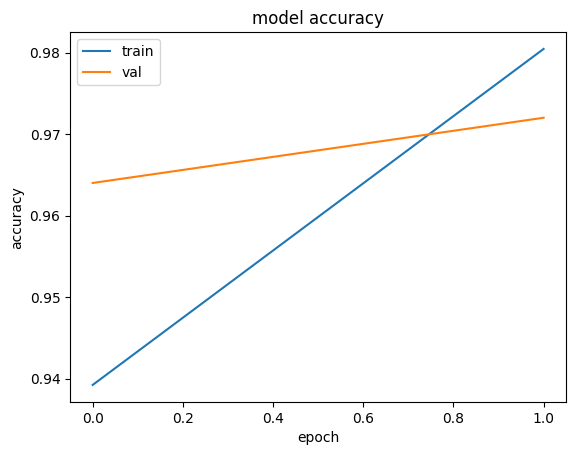

In [ ]:
plt.plot(distill_bert_model_history.history['accuracy'])
plt.plot(distill_bert_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#Model Evaluation

In [ ]:
eval_text = pd.read_csv('/content/drive/MyDrive/evaluation/eval_text.csv')

eval_text = eval_text.astype({'text': str, 'label': bool})

eval_text = shuffle(eval_text)

In [ ]:
eval_texts = pd.Series(data=eval_text['text'])
eval_labels = pd.Series(data=eval_text['label'])

In [ ]:
print(eval_text.head())

                                                    text  label
3395   No wikileakes from Kim Dotcom... nothing... zi...   True
9264   The United Nations said on Monday it has pulle...  False
7711   Alabama Governor Robert Bentley resigned on Mo...  False
12311  Zelenskyy was elected by Ukrainian oligarchs, ...   True
11639  Belarus does not want to be at the front line ...   True


In [ ]:
print(eval_labels.shape)

(15000,)


In [ ]:
max_length = 200

In [ ]:
base_eval_encodings = bert_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=200, return_tensors='tf')
base_eval_inputs = [base_eval_encodings.input_ids,
                    base_eval_encodings.token_type_ids,
                    base_eval_encodings.attention_mask]

distilroberta_eval_encodings = distilroberta_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=200, return_tensors='tf')
distilroberta_eval_inputs = [distilroberta_eval_encodings.input_ids,
                             distilroberta_eval_encodings.attention_mask]

distilbert_eval_encodings = distilbert_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=200, return_tensors='tf')
distilbert_eval_inputs = [distilbert_eval_encodings.input_ids,
                          distilbert_eval_encodings.attention_mask]

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/small/batch4/'

small_bert_base_model_batch4 = create_model('bert_base_cased', bert_base_cased, max_length)
checkpoint_filepath = checkpoint_dir + 'bert_base_weights.02-0.97.hdf5'
small_bert_base_model_batch4.load_weights(checkpoint_filepath)

small_distilroberta_model_batch4 = create_model('distilroberta', distilroberta, max_length)
checkpoint_filepath = checkpoint_dir + 'distilroberta_weights.02-0.97.hdf5'
small_distilroberta_model_batch4.load_weights(checkpoint_filepath)

small_distill_bert_model_batch4 = create_model('distilbert', distilbert, max_length)
checkpoint_filepath = checkpoint_dir + 'distilbert_weights.02-0.94.hdf5'
small_distill_bert_model_batch4.load_weights(checkpoint_filepath)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/small/batch8/'

small_bert_base_model_batch8 = create_model('bert_base_cased', bert_base_cased, max_length)
checkpoint_filepath = checkpoint_dir + 'bert_base_weights.02-0.97.hdf5'
small_bert_base_model_batch8.load_weights(checkpoint_filepath)

small_distilroberta_model_batch8 = create_model('distilroberta', distilroberta, max_length)
checkpoint_filepath = checkpoint_dir + 'distilroberta_weights.02-0.99.hdf5'
small_distilroberta_model_batch8.load_weights(checkpoint_filepath)

small_distill_bert_model_batch8 = create_model('distilbert', distilbert, max_length)
checkpoint_filepath = checkpoint_dir + 'distilbert_weights.02-0.96.hdf5'
small_distill_bert_model_batch8.load_weights(checkpoint_filepath)

In [ ]:
max_length = 500

In [ ]:
large_base_eval_encodings = bert_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=500, return_tensors='tf')
large_base_eval_inputs = [large_base_eval_encodings.input_ids,
                          large_base_eval_encodings.token_type_ids,
                          large_base_eval_encodings.attention_mask]

large_distilroberta_eval_encodings = distilroberta_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=500, return_tensors='tf')
large_distilroberta_eval_inputs = [large_distilroberta_eval_encodings.input_ids,
                                   large_distilroberta_eval_encodings.attention_mask]

large_distilbert_eval_encodings = distilbert_tokenizer(list(eval_texts), truncation=True, padding=True, max_length=500, return_tensors='tf')
large_distilbert_eval_inputs = [large_distilbert_eval_encodings.input_ids,
                                large_distilbert_eval_encodings.attention_mask]

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/large/batch4/'

large_bert_base_model_batch4 = create_model('bert_base_cased', bert_base_cased, max_length)
checkpoint_filepath = checkpoint_dir + 'bert_base_weights.02-0.98.hdf5'
large_bert_base_model_batch4.load_weights(checkpoint_filepath)

large_distilroberta_model_batch4 = create_model('distilroberta', distilroberta, max_length)
checkpoint_filepath = checkpoint_dir + 'distilroberta_weights.02-0.98.hdf5'
large_distilroberta_model_batch4.load_weights(checkpoint_filepath)

large_distill_bert_model_batch4 = create_model('distilbert', distilbert, max_length)
checkpoint_filepath = checkpoint_dir + 'distilbert_weights.02-0.97.hdf5'
large_distill_bert_model_batch4.load_weights(checkpoint_filepath)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/large/batch8/'

large_bert_base_model_batch8 = create_model('bert_base_cased', bert_base_cased, max_length)
checkpoint_filepath = checkpoint_dir + 'bert_base_weights.02-0.98.hdf5'
large_bert_base_model_batch8.load_weights(checkpoint_filepath)

large_distilroberta_model_batch8 = create_model('distilroberta', distilroberta, max_length)
checkpoint_filepath = checkpoint_dir + 'distilroberta_weights.02-1.00.hdf5'
large_distilroberta_model_batch8.load_weights(checkpoint_filepath)

large_distill_bert_model_batch8 = create_model('distilbert', distilbert, max_length)
checkpoint_filepath = checkpoint_dir + 'distilbert_weights.02-0.96.hdf5'
large_distill_bert_model_batch8.load_weights(checkpoint_filepath)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [ ]:
wrong_guesses = {}  # Save indices of wrong guesses so we can look at them later

small_bert_base_model_batch4
469/469 [==============================] - 210s 440ms/step
              precision    recall  f1-score   support

       False       1.00      0.00      0.00      5000
        True       0.67      1.00      0.80     10000

    accuracy                           0.67     15000
   macro avg       0.83      0.50      0.40     15000
weighted avg       0.78      0.67      0.53     15000

small_distilroberta_model_batch4
469/469 [==============================] - 103s 217ms/step
              precision    recall  f1-score   support

       False       1.00      0.91      0.95      5000
        True       0.96      1.00      0.98     10000

    accuracy                           0.97     15000
   macro avg       0.98      0.96      0.97     15000
weighted avg       0.97      0.97      0.97     15000

small_distill_bert_model_batch4
469/469 [==============================] - 103s 216ms/step
              precision    recall  f1-score   support

       False       0

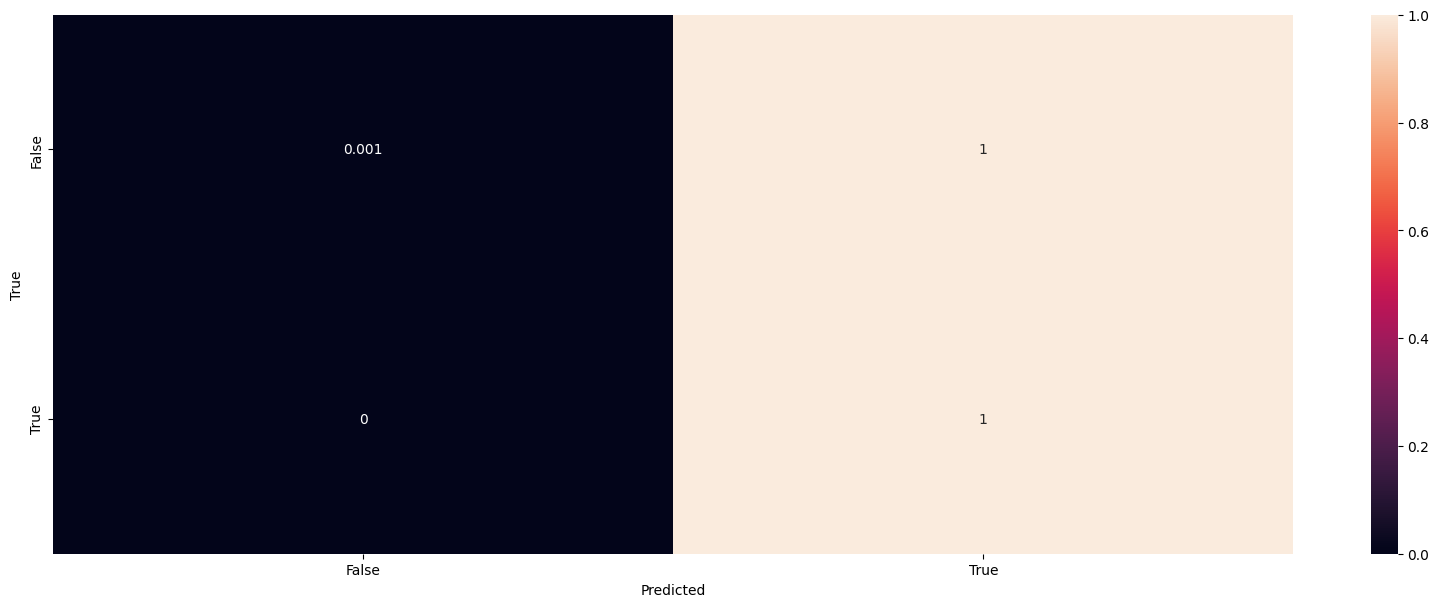

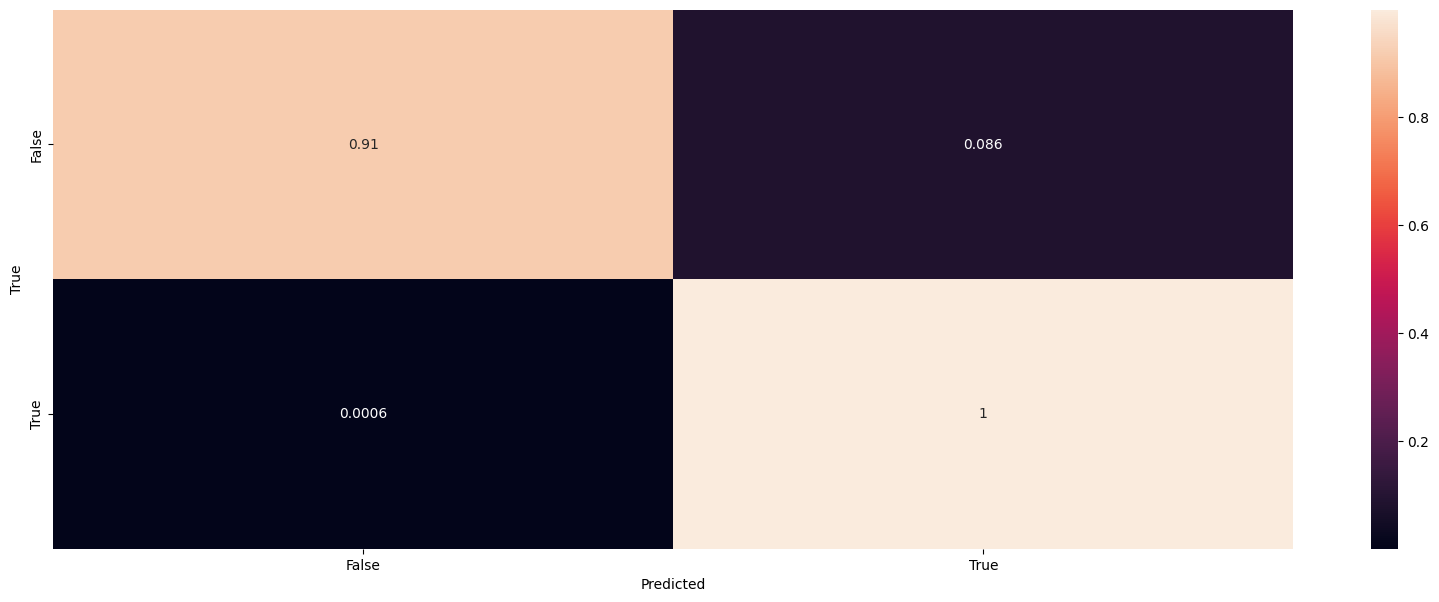

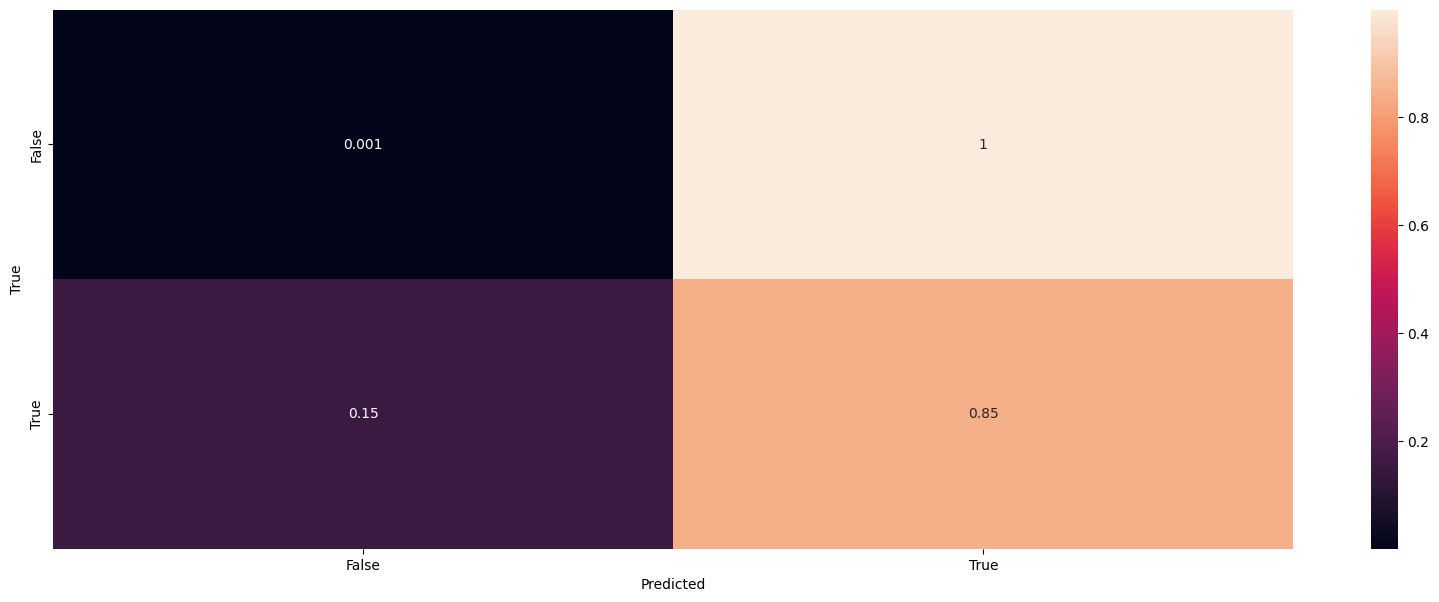

In [ ]:
bert_models = ['small_bert_base_model_batch4', 'small_distilroberta_model_batch4', 'small_distill_bert_model_batch4']
bert_model_dict = {'small_bert_base_model_batch4': small_bert_base_model_batch4, 'small_distilroberta_model_batch4': small_distilroberta_model_batch4, 'small_distill_bert_model_batch4': small_distill_bert_model_batch4}
eval_data = {'small_bert_base_model_batch4': base_eval_inputs, 'small_distilroberta_model_batch4': distilroberta_eval_inputs, 'small_distill_bert_model_batch4': distilbert_eval_inputs}

label_names = eval_text.groupby(['label'], as_index=False).sum()['label']

for i in range(len(bert_models)):
  print(bert_models[i])
  probs = bert_model_dict[bert_models[i]].predict(eval_data[bert_models[i]])
  pred = np.squeeze(probs >= 0.5)
  print(classification_report(eval_labels, pred))
  plot_confusion_matrix(eval_labels, pred, label_names)

  wrong_guesses[bert_models[i]] = np.where(eval_labels != pred)

small_bert_base_model_batch8
469/469 [==============================] - 208s 437ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.33      1.00      0.50      5000
        True       0.00      0.00      0.00     10000

    accuracy                           0.33     15000
   macro avg       0.17      0.50      0.25     15000
weighted avg       0.11      0.33      0.17     15000

small_distilroberta_model_batch8
469/469 [==============================] - 103s 216ms/step
              precision    recall  f1-score   support

       False       0.33      1.00      0.50      5000
        True       1.00      0.00      0.01     10000

    accuracy                           0.34     15000
   macro avg       0.67      0.50      0.25     15000
weighted avg       0.78      0.34      0.17     15000

small_distill_bert_model_batch8
469/469 [==============================] - 103s 216ms/step
              precision    recall  f1-score   support

       False       0.32      0.83      0.46      5000
        True       0.60      0.12      0.21     10000


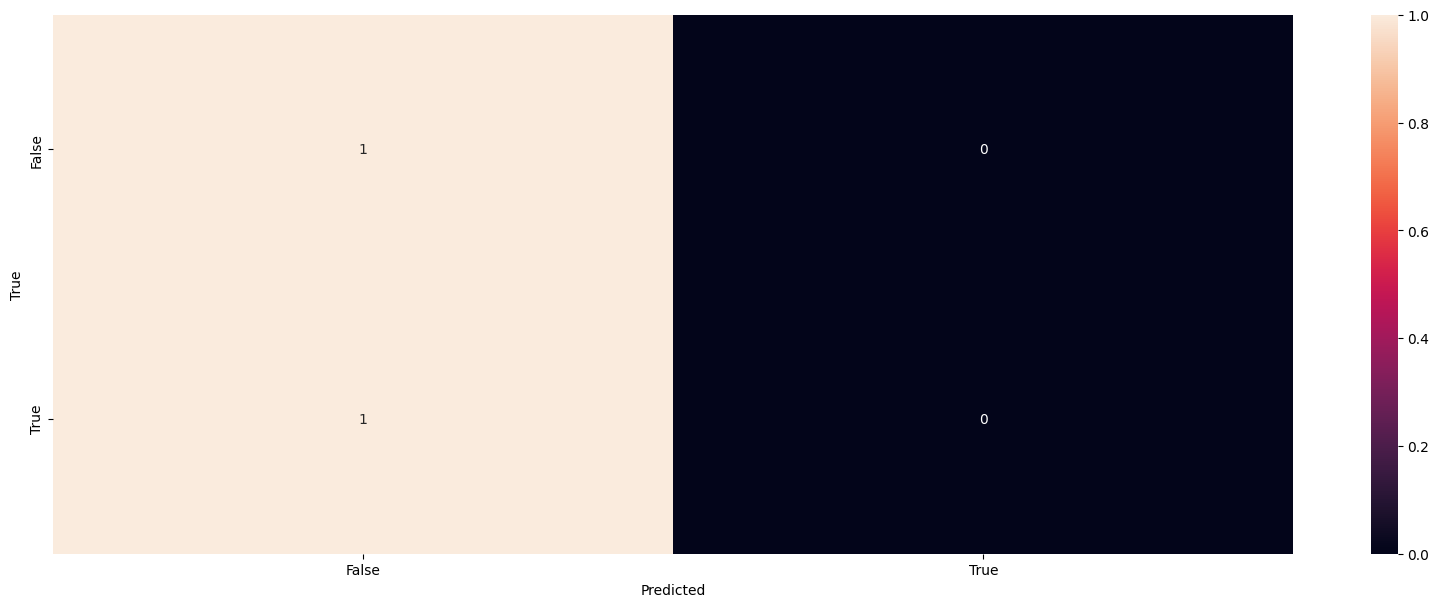

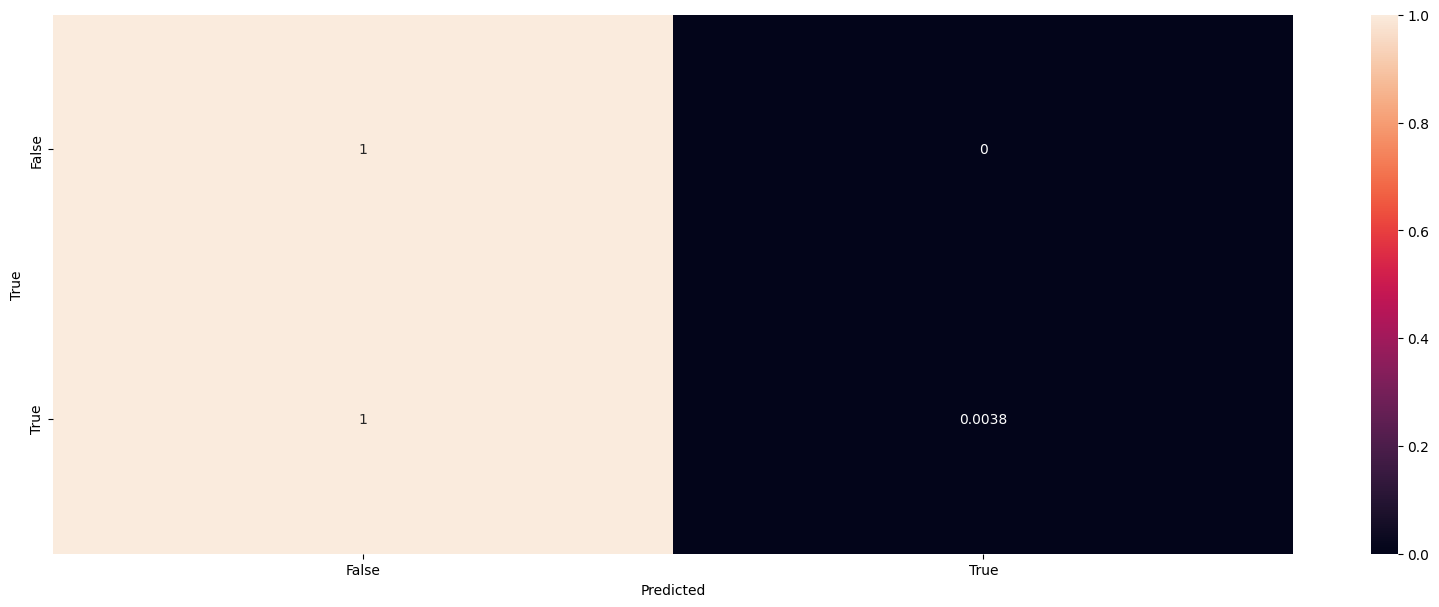

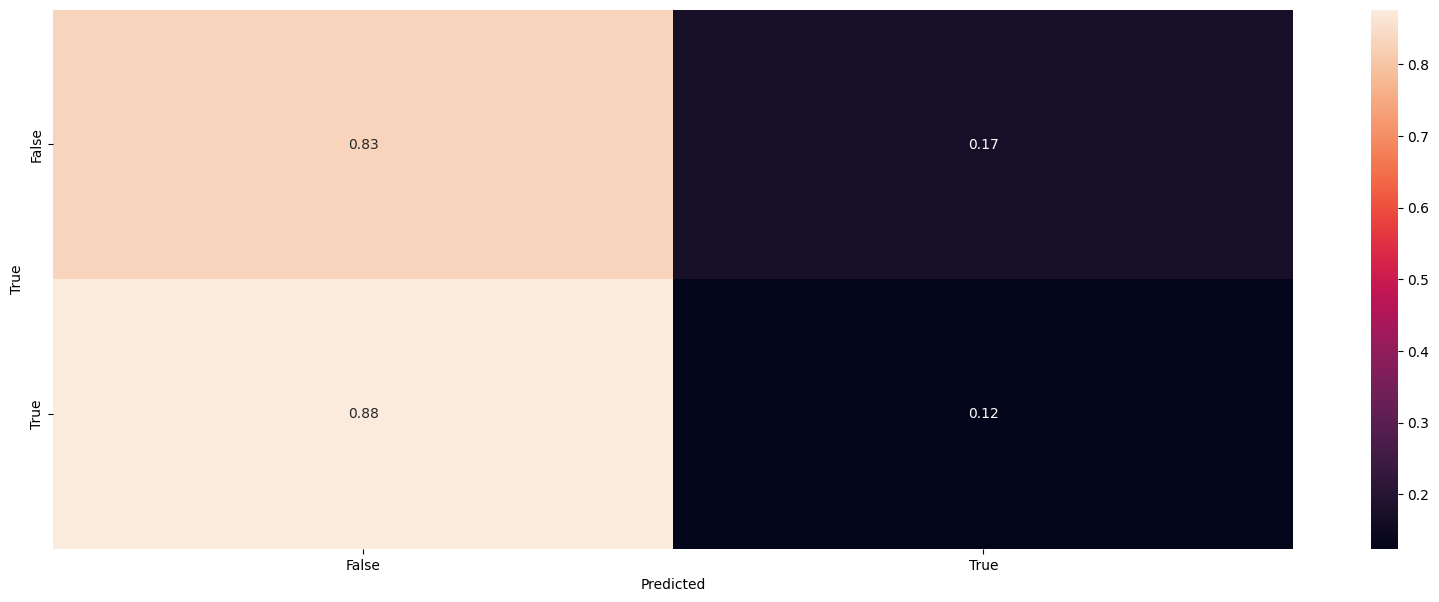

In [ ]:
bert_models = ['small_bert_base_model_batch8', 'small_distilroberta_model_batch8', 'small_distill_bert_model_batch8']
bert_model_dict = {'small_bert_base_model_batch8': small_bert_base_model_batch8, 'small_distilroberta_model_batch8': small_distilroberta_model_batch8, 'small_distill_bert_model_batch8': small_distill_bert_model_batch8}
eval_data = {'small_bert_base_model_batch8': base_eval_inputs, 'small_distilroberta_model_batch8': distilroberta_eval_inputs, 'small_distill_bert_model_batch8': distilbert_eval_inputs}

label_names = eval_text.groupby(['label'], as_index=False).sum()['label']

for i in range(len(bert_models)):
  print(bert_models[i])
  probs = bert_model_dict[bert_models[i]].predict(eval_data[bert_models[i]])
  pred = np.squeeze(probs >= 0.5)
  print(classification_report(eval_labels, pred))
  plot_confusion_matrix(eval_labels, pred, label_names)

  wrong_guesses[bert_models[i]] = np.where(eval_labels != pred)

large_bert_base_model_batch4
469/469 [==============================] - 587s 1s/step
              precision    recall  f1-score   support

       False       0.74      0.07      0.13      5000
        True       0.68      0.99      0.81     10000

    accuracy                           0.68     15000
   macro avg       0.71      0.53      0.47     15000
weighted avg       0.70      0.68      0.58     15000

large_distilroberta_model_batch4
469/469 [==============================] - 287s 609ms/step
              precision    recall  f1-score   support

       False       1.00      0.57      0.73      5000
        True       0.82      1.00      0.90     10000

    accuracy                           0.86     15000
   macro avg       0.91      0.78      0.81     15000
weighted avg       0.88      0.86      0.84     15000

large_distill_bert_model_batch4
469/469 [==============================] - 286s 606ms/step
              precision    recall  f1-score   support

       False       0.96

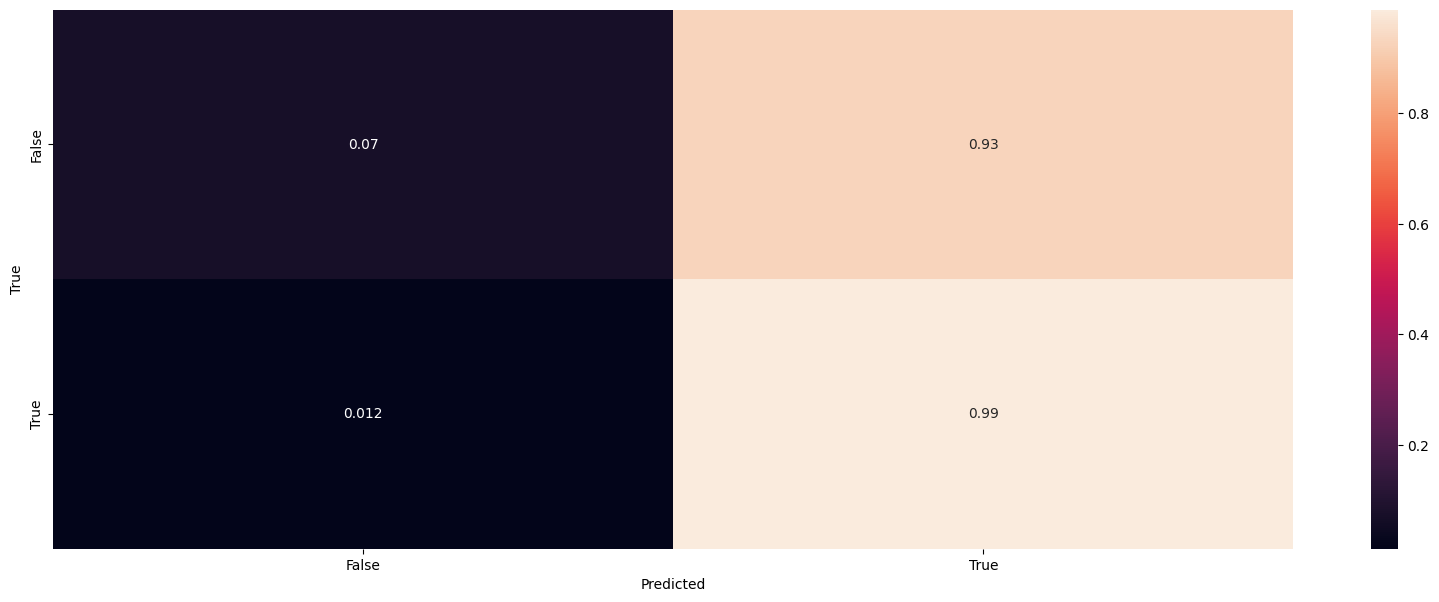

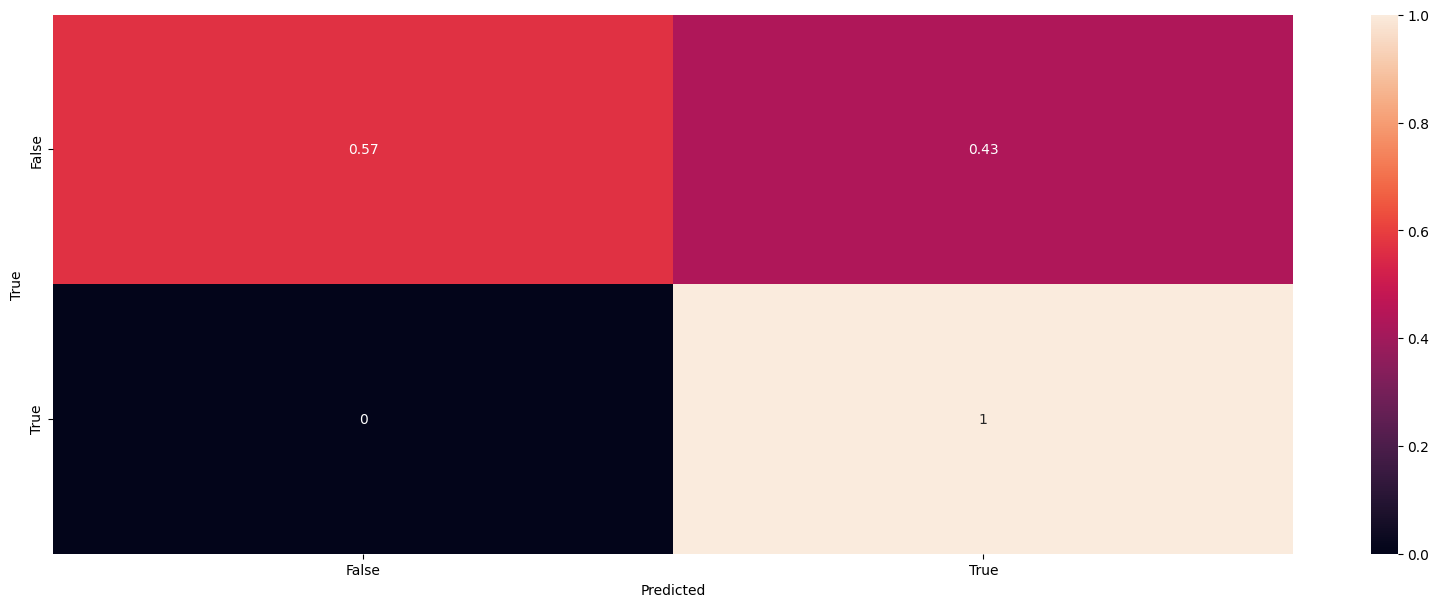

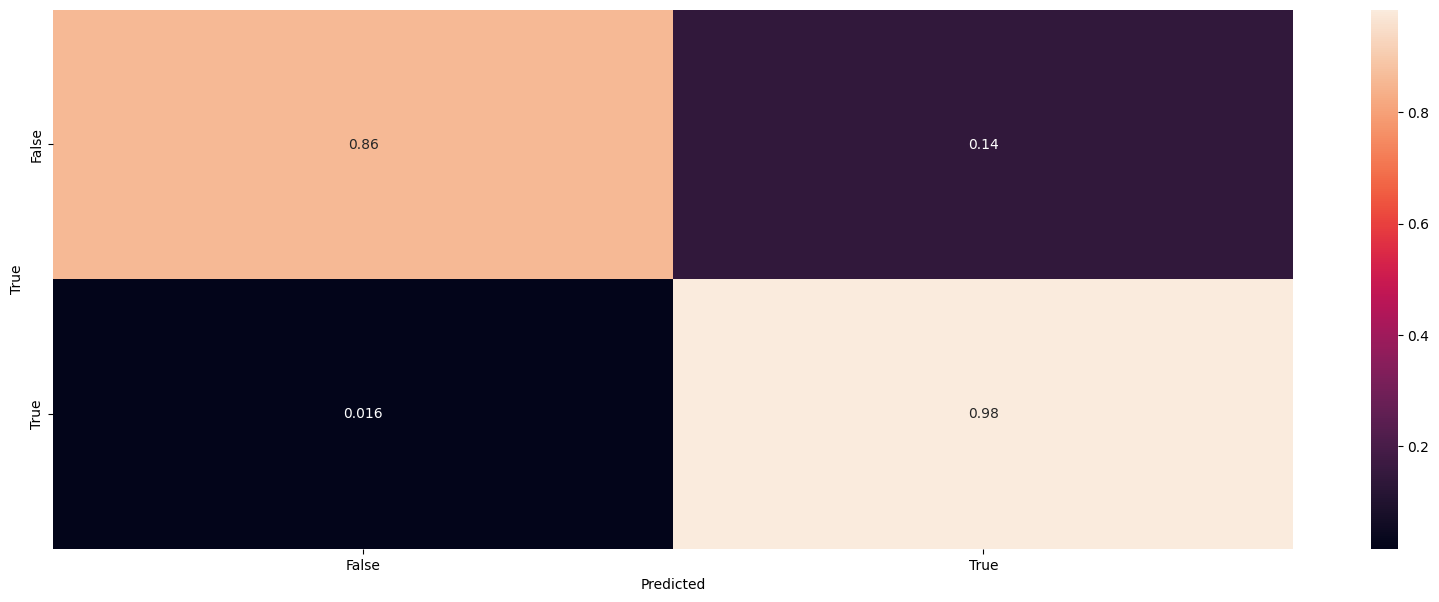

In [ ]:
bert_models = ['large_bert_base_model_batch4', 'large_distilroberta_model_batch4', 'large_distill_bert_model_batch4']
bert_model_dict = {'large_bert_base_model_batch4': large_bert_base_model_batch4, 'large_distilroberta_model_batch4': large_distilroberta_model_batch4, 'large_distill_bert_model_batch4': large_distill_bert_model_batch4}
eval_data = {'large_bert_base_model_batch4': large_base_eval_inputs, 'large_distilroberta_model_batch4': large_distilroberta_eval_inputs, 'large_distill_bert_model_batch4': large_distilbert_eval_inputs}

label_names = eval_text.groupby(['label'], as_index=False).sum()['label']

for i in range(len(bert_models)):
  print(bert_models[i])
  probs = bert_model_dict[bert_models[i]].predict(eval_data[bert_models[i]])
  pred = np.squeeze(probs >= 0.5)
  print(classification_report(eval_labels, pred))
  plot_confusion_matrix(eval_labels, pred, label_names)

  wrong_guesses[bert_models[i]] = np.where(eval_labels != pred)

large_bert_base_model_batch8
469/469 [==============================] - 588s 1s/step
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      5000
        True       0.99      0.99      0.99     10000

    accuracy                           0.99     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.99      0.99      0.99     15000

large_distilroberta_model_batch8
469/469 [==============================] - 288s 610ms/step
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      5000
        True       1.00      1.00      1.00     10000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

large_distill_bert_model_batch8
469/469 [==============================] - 285s 605ms/step
              precision    recall  f1-score   support

       False       0.91

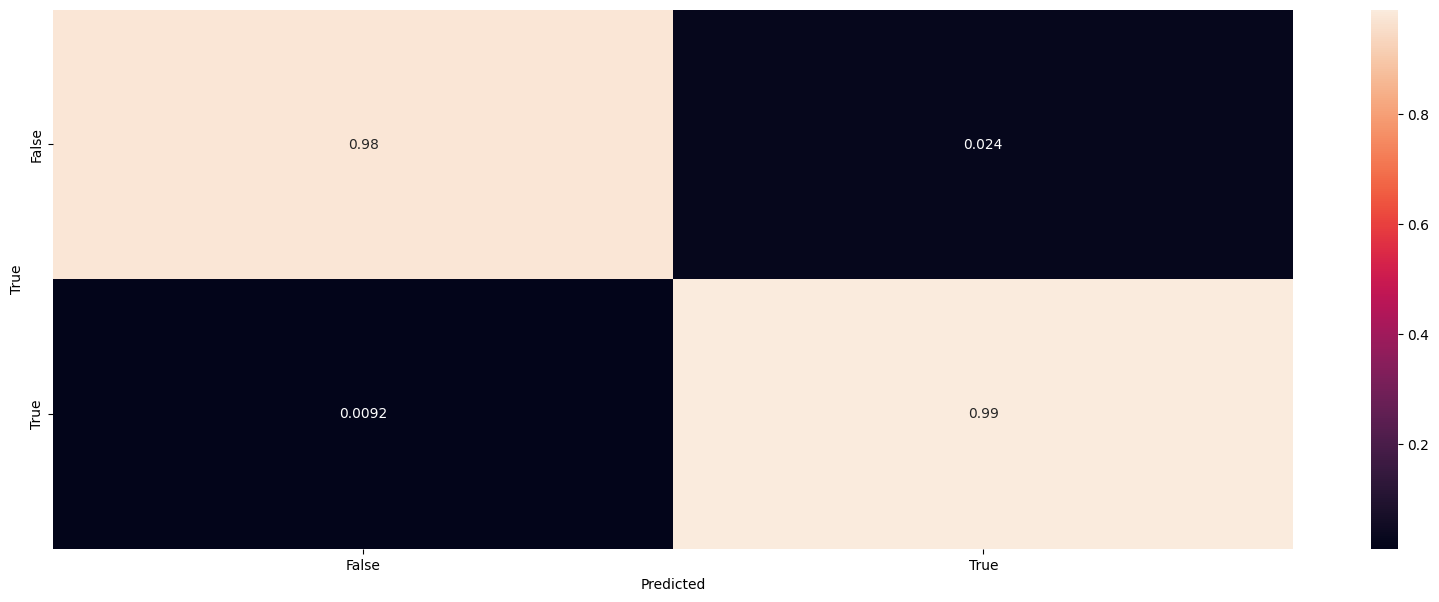

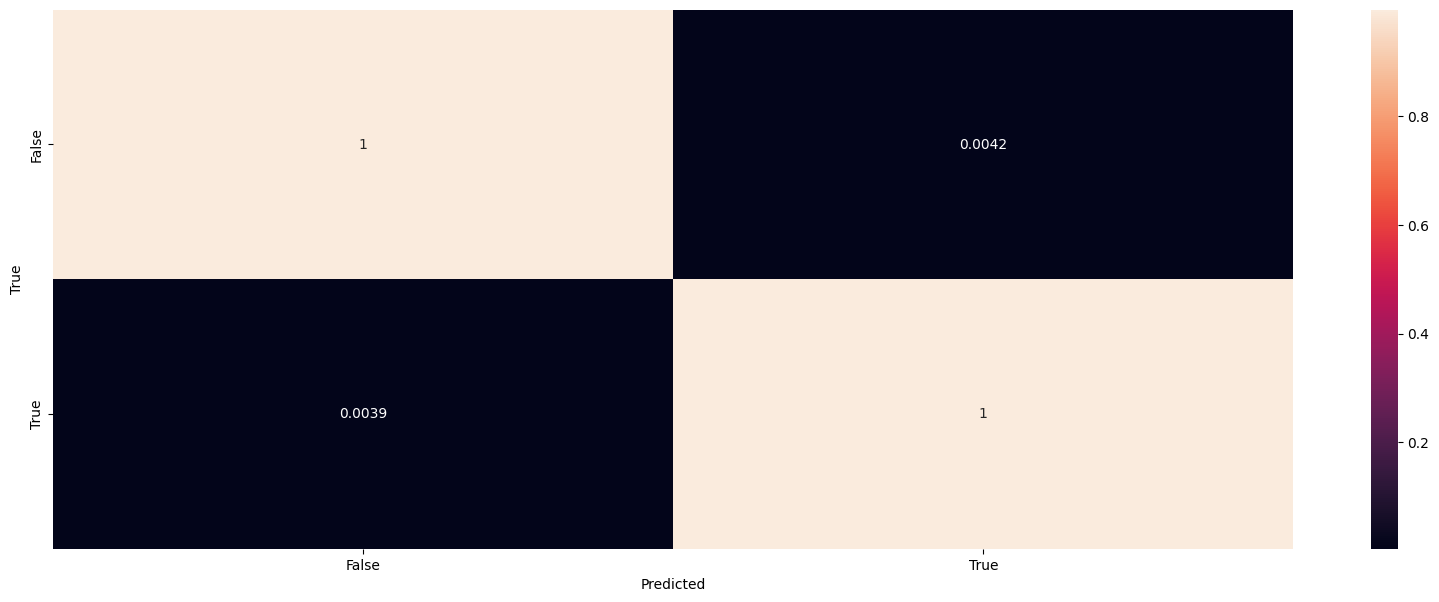

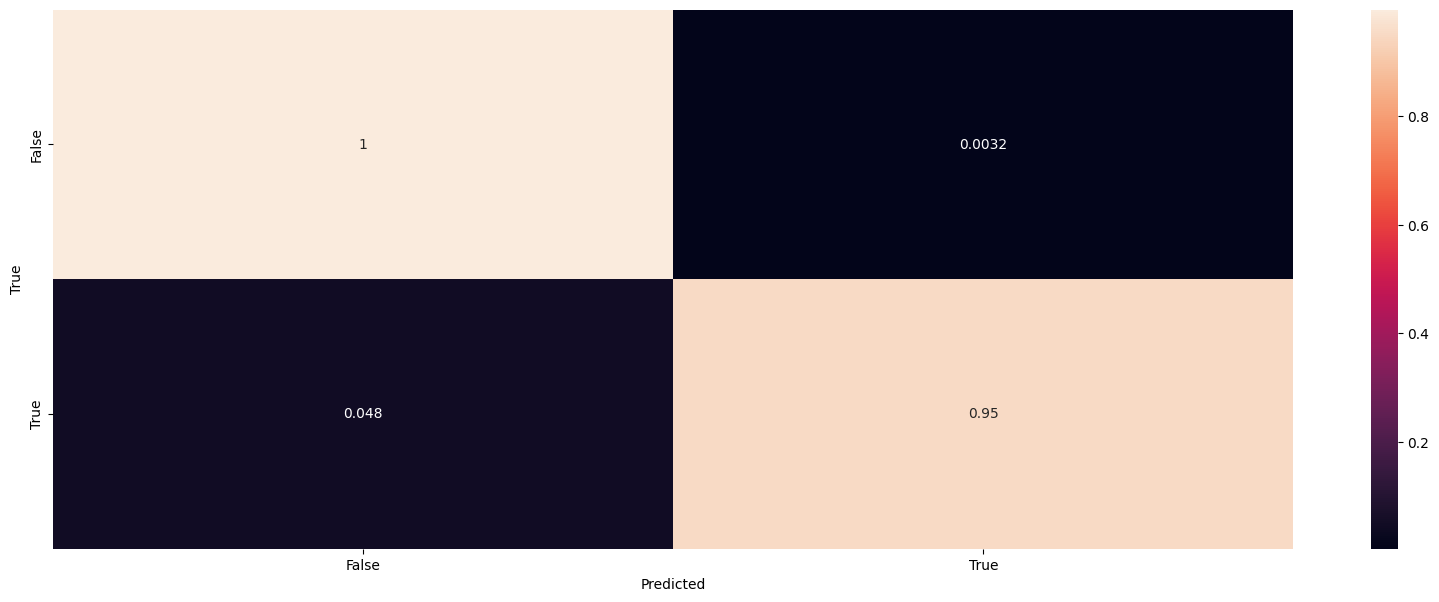

In [ ]:
bert_models = ['large_bert_base_model_batch8', 'large_distilroberta_model_batch8', 'large_distill_bert_model_batch8']
bert_model_dict = {'large_bert_base_model_batch8': large_bert_base_model_batch8, 'large_distilroberta_model_batch8': large_distilroberta_model_batch8, 'large_distill_bert_model_batch8': large_distill_bert_model_batch8}
eval_data = {'large_bert_base_model_batch8': large_base_eval_inputs, 'large_distilroberta_model_batch8': large_distilroberta_eval_inputs, 'large_distill_bert_model_batch8': large_distilbert_eval_inputs}

label_names = eval_text.groupby(['label'], as_index=False).sum()['label']

for i in range(len(bert_models)):
  print(bert_models[i])
  probs = bert_model_dict[bert_models[i]].predict(eval_data[bert_models[i]])
  pred = np.squeeze(probs >= 0.5)
  print(classification_report(eval_labels, pred))
  plot_confusion_matrix(eval_labels, pred, label_names)

  wrong_guesses[bert_models[i]] = np.where(eval_labels != pred)

# Mis-classified article sample

In [ ]:
wrong_examples_small_batch4 = np.intersect1d(wrong_guesses['small_bert_base_model_batch4'],
                                             wrong_guesses['small_distilroberta_model_batch4'],
                                             wrong_guesses['small_distill_bert_model_batch4'])

for i in wrong_examples_small_batch4[:10]:
  print(eval_texts[i])
  print(eval_labels[i])

10,300 10,300 likes 
Unreal! We live in fascinating, exciting times, brothers! 
Other such public actions of retribution have coincided with this(ie CNN actually firing Donna Brazile for being a despicable hack). These are remarkable turnarounds, but what could be behind this? If the democratic leadership is turning on Hillary, why would they do this? What’s their reasoning for doing so? What’s in it for them? Well, the answers would surprise many, but are logical if thought through. 
Saving Face and Saving Brand 
Hillary Clinton is a sociopathic criminal, guilty of treason, mass murder for profit, and lining the pockets of globalists at our expense. We know that folks like us, in the Alt-media, and #AltRight etc all know that…but the “blue-pilled”, “normie” public, has, up until this point…not known that! 
All these O’Keefe, Wikileaks, and whistleblower revelations about Hillary and Washington DC are news to tens of millions of people. Some still haven’t heard this news, others still 

In [ ]:
wrong_examples_small_batch8 = np.intersect1d(wrong_guesses['small_bert_base_model_batch8'],
                                             wrong_guesses['small_distilroberta_model_batch8'],
                                             wrong_guesses['small_distill_bert_model_batch8'])

for i in wrong_examples_small_batch8[:10]:
  print(eval_texts[i])
  print(eval_labels[i])

Carl G. Jung Attitude Types and the Sash of Solitude Nov 8, 2016 0 0 
Jung believed that our orientation to the world was a foundational aspect of our personality. Jung identified was the two opposite ways in which we adapt to, or orient ourselves to, the world. These are Jung’s attitudes of Extraversion and Introversion. Extraversion – Our energy moves toward the outer world of people, places and things; the world outside of us. Introversion – Our energy moves toward the inner world of thoughts and ideas; the world inside of us. Loneliness vs. Solitude 
As human beings, we are social creatures and, without others around us from birth, we would not even be able to stay alive in this world. Social space plays a crucial role in the development of our personality, as the direction of our development is determined by the expectations of other people and our desire to meet those expectations. That is how we become a part of a collective, social space called society, and society receives its

In [ ]:
wrong_examples_large_batch4 = np.intersect1d(wrong_guesses['large_bert_base_model_batch4'],
                                             wrong_guesses['large_distilroberta_model_batch4'],
                                             wrong_guesses['large_distill_bert_model_batch4'])

for i in wrong_examples_large_batch4[:10]:
  print(eval_texts[i])
  print(eval_labels[i])

Hillary Clinton will be back in the spotlight this fall for an unprecedented, big-ticket book tour for her new tome What Happened, with tickets priced as high as $1,200.On Monday, the ex-Democratic nominee announced  Hillary Clinton Live,  a 15-city tour, which includes stops in a handful of states she lost in the election last year.The astronomically priced tickets for Hillary s loser tour, certainly begs the question:  If no one came to see Hillary at her rallies (for free) when she was running for president, why would they pay $1,200 to hear the even more irrelevant Hillary Clinton whine about why she lost to Trump? Promotional materials for her first stop, at the Warner Theatre in Washington, D.C., promises Clinton plans to  let loose  and tell her audience a  personal, raw, detailed and surprisingly funny story  of her election loss and recovery.The website promoting the tour, HillaryClintonBookTour.com, features a quote from Clinton too. In the past, for reasons I try to explain,

In [ ]:
wrong_examples_large_batch8 = np.intersect1d(wrong_guesses['large_bert_base_model_batch8'],
                                             wrong_guesses['large_distilroberta_model_batch8'],
                                             wrong_guesses['large_distill_bert_model_batch8'])

for i in wrong_examples_large_batch8[:10]:
  print(eval_texts[i])
  print(eval_labels[i])

We Are Change 
Often times we are blind to what is happening around us. Just because we cannot see the effects of pollution and over-stripping the Earth of her resources in our own backyards, doesn’t mean that it isn’t a very serious concern. Closing our eyes to these issues is not going to help the problems go away. The world used to be an absolutely beautiful place, but that beauty is slowly being pushed out by the trash of mankind. We are consuming more than what this Earth can handle and pretty soon the Earth will no longer be able to sustain mankind. Here are 27 pictures that will open your eyes to the serious danger that our very existence is in.
H/T Jill Stein & Unreal-Lists 
Please remember to subscribe To We Are Change and stay up to date with daily Videos.

Follow WE ARE CHANGE on SOCIAL MEDIA SnapChat: LukeWeAreChange 
fbook: https://facebook.com/LukeWeAreChange 
Twitter: https://twitter.com/Lukewearechange I nstagram: http://instagram.com/lukewearechange Sign up become a pa

In [ ]:
# all small and large batch 4 models got this one wrong
print(eval_texts[0])
print(eval_labels[0])

Carl G. Jung Attitude Types and the Sash of Solitude Nov 8, 2016 0 0 
Jung believed that our orientation to the world was a foundational aspect of our personality. Jung identified was the two opposite ways in which we adapt to, or orient ourselves to, the world. These are Jung’s attitudes of Extraversion and Introversion. Extraversion – Our energy moves toward the outer world of people, places and things; the world outside of us. Introversion – Our energy moves toward the inner world of thoughts and ideas; the world inside of us. Loneliness vs. Solitude 
As human beings, we are social creatures and, without others around us from birth, we would not even be able to stay alive in this world. Social space plays a crucial role in the development of our personality, as the direction of our development is determined by the expectations of other people and our desire to meet those expectations. That is how we become a part of a collective, social space called society, and society receives its

In [ ]:
# all small batch 8 models got this one wrong
print(eval_texts[2])
print(eval_labels[2])

Donald Trump: The next President of the United States of America   Donald Trump will be the new President of the United States of America . Trump won 276 electoral votes with the necessary minimum of 270 votes. During his speech as the winner, Trump has promised the Americans to be president for all citizens of the country. According to him, America will not be satisfied with anything but the best. At the same time, the newly elected president has promised to seek common ground, not enmity, with partners in the world. formal voting procedure for electors will be held on December 19 and January 6, 2017, Congress will adopt its outcome. The inauguration of the president-elect is scheduled for 20 January. To win the election, a candidate needs to enlist the support of 270 electors. The procedure for their formal vote will be held on December 19, while on January 6, 2017 Congress will approve its results. The inauguration is scheduled for January 20, when the US president-elect takes offic

In [ ]:
# large batch 8 distilroberta and base case got this wrong
print(eval_texts[13951])
print(eval_labels[13951])

The migration wave is part of preparations for the New World Order, says analyst David Icke.
True


In [ ]:
# large batch 8 distilbert and base case got this wrong
print(eval_texts[14944])
print(eval_labels[14944])

Polish policy towards Russia is entirely based on the support of the United States.
True
